In [1]:
import stim
import sinter
import matplotlib.pyplot as plt
from surface_erasure_decoding.sur_builder import easure_circ_builder
from surface_erasure_decoding.sur_model import SQE, MQE, Error_mechanism, Gate_error_model
import re
import uuid
import numpy as np

Starting 7 workers...
Finding work...
Running...
    pymatching processes=1  ~core_mins_left=None    (initializing...) {alpha=0.3333333333333333,d=3,p=0.0001}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {alpha=0.98,d=3,p=0.0001}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {alpha=0.3333333333333333,d=3,p=0.00026826957952797245}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {alpha=0.98,d=3,p=0.00026826957952797245}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {alpha=0.3333333333333333,d=3,p=0.0007196856730011522}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {alpha=0.98,d=3,p=0.0007196856730011522}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {alpha=0.3333333333333333,d=3,p=0.0019306977288832496}
Running...
    pymatching processes=2  ~core_mins_left=1       shots_left=46000    errors_left=1000    {alpha=0.98,d=3,p=0.0007196856730011522}
  

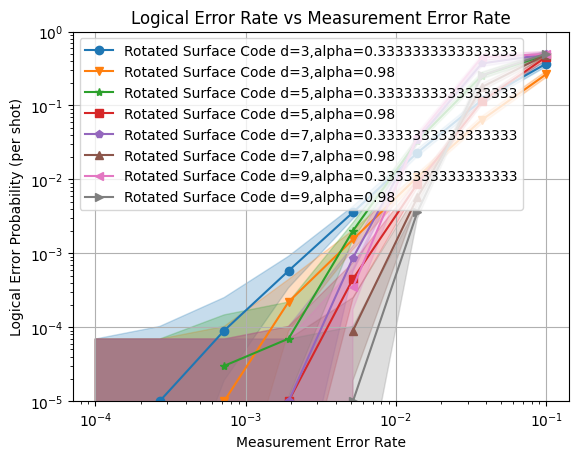

In [5]:
def generate_example_tasks():
    for d in [3, 5, 7, 9]:
        for p in np.logspace(-4, -1, num=8):
            for alpha in [1/3,  0.98]:
                pZ = alpha * p
                pXY = (1-alpha)/2 * p

                normalizing_factor = p / (1-(1-p)**2)
                after_cz_error_model = Gate_error_model(
                    list_of_mechanisms = [
                            Error_mechanism(
                                [   MQE((1-p),[SQE("I",False),SQE("I",False)]),

                                    MQE( (1-p)*pXY*normalizing_factor,[SQE("I",False),SQE("X",False)]),
                                    MQE( (1-p)*pXY*normalizing_factor,[SQE("I",False),SQE("Y",False)]),
                                    MQE( (1-p)*pZ*normalizing_factor,[SQE("I",False),SQE("Z",False)]),

                                    MQE(pXY*(1-p)*normalizing_factor,[SQE("X",False),SQE("I",False)]),
                                    MQE(pXY**2*normalizing_factor,[SQE("X",False),SQE("X",False)]),
                                    MQE(pXY**2*normalizing_factor,[SQE("X",False),SQE("Y",False)]),
                                    MQE(pXY*pZ*normalizing_factor,[SQE("X",False),SQE("Z",False)]),

                                    MQE(pXY*(1-p)*normalizing_factor,[SQE("Y",False),SQE("I",False)]),
                                    MQE(pXY**2*normalizing_factor,[SQE("Y",False),SQE("X",False)]),
                                    MQE(pXY**2*normalizing_factor,[SQE("Y",False),SQE("Y",False)]),
                                    MQE(pXY * pZ*normalizing_factor,[SQE("Y",False),SQE("Z",False)]),

                                    MQE(pZ*(1-p)*normalizing_factor,[SQE("Z",False),SQE("I",False)]),
                                    MQE(pZ*pXY*normalizing_factor,[SQE("Z",False),SQE("X",False)]),
                                    MQE(pZ*pXY*normalizing_factor,[SQE("Z",False),SQE("Y",False)]),
                                    MQE(pZ*pZ*normalizing_factor,[SQE("Z",False),SQE("Z",False)]),
                                ]
                            )
                    ])
                circ_builder = easure_circ_builder(
                    rounds = d,
                    distance = d,
                    after_cz_error_model = after_cz_error_model,

                    native_cz = True,
                    native_cx = False,
                    XZZX = True,
                    is_memory_x = True
                )
                circ_builder.generate_circuit_and_decoding_info()
                circuit = circ_builder.normal_circuit
                
                yield sinter.Task(
                    circuit = circuit,
                    json_metadata={
                        'p': p,
                        'alpha':alpha,
                        'd': d
                    },
                    )

samples = sinter.collect(
    num_workers=7,
    max_shots=100_000,
    max_errors=1000,
    tasks=generate_example_tasks(),
    decoders=['pymatching'],
    print_progress = True
)


In [ ]:

fig, ax = plt.subplots(1, 1)

def get_rotated_surface_code_d(stat):
    return f"Rotated Surface Code d={stat.json_metadata['d']},alpha={stat.json_metadata['alpha']}"

sinter.plot_error_rate(
    ax=ax,
    stats=samples,
    group_func=get_rotated_surface_code_d,
    x_func=lambda stat: stat.json_metadata['p'],
)
ax.loglog()
ax.set_ylim(1e-5, 1)
ax.grid()
ax.set_title('Logical Error Rate vs Measurement Error Rate')
ax.set_ylabel('Logical Error Probability (per shot)')#not per round!
ax.set_xlabel('Measurement Error Rate')
ax.legend()

# Save to file and also open in a window.
# fig.savefig('plot.png')
plt.show()

In [12]:
unbiased_samples = [sample for sample in samples if sample.json_metadata['alpha']==0.3333333333333333]

biased_samples = [sample for sample in samples if sample.json_metadata['alpha']==0.98]

Text(0.5, 1.0, '0.98 bias')

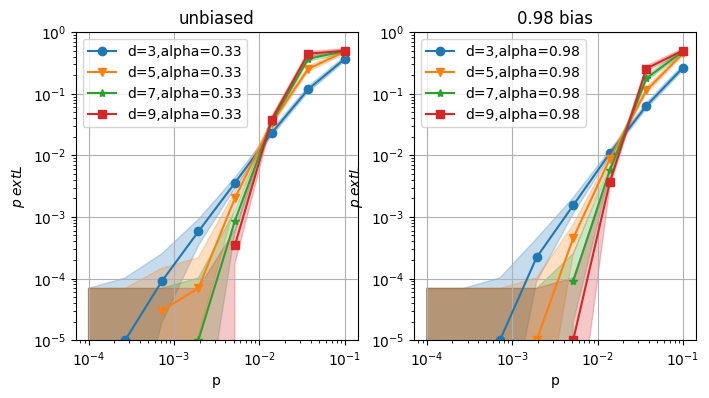

In [ ]:

fig, axes = plt.subplots(1, 2,figsize = (8,4))

def get_rotated_surface_code_d(stat):
    return f"d={stat.json_metadata['d']},alpha={stat.json_metadata['alpha']:.2f}"

sinter.plot_error_rate(
    ax=axes[0],
    stats=unbiased_samples,
    group_func=get_rotated_surface_code_d,
    x_func=lambda stat: stat.json_metadata['p'],
)

sinter.plot_error_rate(
    ax=axes[1],
    stats=biased_samples,
    group_func=get_rotated_surface_code_d,
    x_func=lambda stat: stat.json_metadata['p'],
)

for ax in axes:
    ax.loglog()
    ax.set_ylim(1e-5, 1)
    ax.grid()
    ax.set_ylabel(f'$p_\text{{L}}$')#not per round!
    ax.set_xlabel('p')
    ax.legend()
axes[0].set_title('unbiased')
axes[1].set_title('0.98 bias')
